This notebook will demonstrate how to train a model on the backward digit span data.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from time import time
import os

## Pre-processing a subject's data

The first thing we need to do is load all the data used for prediction into a single dataset, which means downsampling everything to the lowest sampling rate. In practice, I've packaged all this into a `load_proprocessed_subject_data` function, so this section is really just an explainer. 

In [2]:
def load_data(sub, data_type):
    fpath = os.path.join('dataset', sub, '%s.csv'%data_type)
    with open(fpath, 'r') as f:
        tmin = float(f.readline().split(',')[0])
        fs = float(f.readline().split(',')[0])
        if data_type == 'ACC':
            hdr = ['x', 'y', 'z']
        else:
            hdr = [data_type]
        df = pd.read_csv(f, names = hdr)
    times = np.array(range(df.shape[0]))/fs + tmin
    df['timestamps'] = times
    return df, fs

In [3]:
subjects = [f for f in os.listdir('dataset') if '.' not in f]
sub = subjects[0]
print(sub)

vignesh


In [4]:
# load data
eda, eda_fs = load_data(sub, 'EDA')
hr, hr_fs = load_data(sub, 'HR')
acc, acc_fs = load_data(sub, 'ACC')

Scipy has some off-the-shelf functions that will downsample for you, handling the necessary anti-alias filtering, but those will use a no-phase-shift filter, which is impossible to replicate in real-time. Since we ultimately want the model to make predictions in real time, we'll use a single pole lowpass filter before downsampling. This way, there will be a phase shift commensurate with that imposed by our real-time filters present in the training data.

In [5]:
from scipy.signal import butter, lfilter
fs = min(eda_fs, hr_fs, acc_fs) # the lowest sampling rate
lc = fs/2 # lowpass cutoff frequency 
print('Anti-alias cutoff frequency: {:.2f} Hz'.format(lc))
def lowpass(sgnl, sgnl_srate):
    b, a = butter(1, lc, btype = 'highpass', fs = sgnl_srate)
    return lfilter(b, a, sgnl)
def lowpass_df(sgnl_df):
    t = sgnl_df.timestamps
    dat_fs = 1/(t[1] - t[0])
    for col in sgnl_df.columns:
        if col != 'timestamps':
            dat = sgnl_df[col]
            sgnl_df[col] = lowpass(dat, dat_fs)
    return sgnl_df

Anti-alias cutoff frequency: 0.50 Hz


In [6]:
# we don't need to lowpass HR cause it's already the lowest freq
eda = lowpass_df(eda)
acc = lowpass_df(acc)

Now that we've applied our anti-alias filter, we can safely align and downsample time series.

In [7]:
data = pd.merge_asof(hr, eda, on = 'timestamps')
data = pd.merge_asof(data, acc, on = 'timestamps')
data.dropna(inplace = True)
data['score'] = 0
data['offload'] = 0
data.head()

,HR,timestamps,EDA,x,y,z,score,offload
0,60.0,1.630938e+09,-0.000522,16.805329,8.730372,-0.774909,0,0
1,60.5,1.630938e+09,-0.000262,0.311950,-0.280745,-0.791776,0,0
2,77.0,1.630938e+09,-0.262255,-28.101831,-7.398621,7.974736,0,0
3,82.0,1.630938e+09,-0.055351,16.267614,0.869266,9.628312,0,0
4,87.4,1.630938e+09,-0.063581,-41.253585,-4.966089,-7.400527,0,0


Now let's annotate our time-series data with condition labels, so we have something to predict.

In [8]:
def load_tags(sub):
    fpath = os.path.join('dataset', sub, 'tags.csv')
    with open(fpath, 'r') as f:
        txt = f.read()
    tags = [float(s) for s in txt.split('\n') if s]
    tags = np.array(tags)
    return tags

In [9]:
def load_indicators(sub):
    fpath = os.path.join('', 'score_and_help_indicator.csv')
    ind = pd.read_csv(fpath)
    loads = [ind['%dbds'%(trial+1)].loc[ind.name == sub].values[0] 
         for trial in range(tags.shape[0]//2-1)]
    offload = [ind['%dhelp'%(trial+1)].loc[ind.name == sub].values[0] 
         for trial in range(tags.shape[0]//2-1)]
    loads = np.array([0] + loads) # starts with rest a.k.a. no load
    offload = np.array([0] + offload)
    return loads, offload

In [10]:
tags = load_tags(sub)
loads, offloads = load_indicators(sub)

dfs = []
for i in range(len(loads)):
    ii = i*2
    jj = ii + 1
    ends = (tags[ii], tags[jj])
    trial = (data.timestamps > ends[0]) & (data.timestamps < ends[1])
    df = data[trial]
    df.load = loads[i]
    df.offload = offloads[i]
    dfs.append(df)   
df = pd.concat(dfs)

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Note that the above step, in addition to annotating the data, also removed data that were not contained within a block/trial.

After that, we no longer need the exact timestamps.

In [11]:
df = df.drop(columns = ['timestamps'])
df.head()

,HR,EDA,x,y,z,score,offload
216,143.28,0.000960,-5.237948,2.281481,0.878243,0,0
217,142.45,0.000157,0.266837,-0.091387,-0.002079,0,0
218,141.60,-0.001834,0.322753,0.181748,0.953084,0,0
219,140.43,-0.000027,-2.717171,1.227492,0.069092,0,0
220,139.28,-0.000907,0.102099,0.345384,-0.003234,0,0


Since we actually want to train on all the subjects' data at once, I've packaged that whole procedure into a function, `util.preprocessing.load_proprocessed_subject_data`.

## Fitting the Model

In [12]:
from util.preprocessing import load_proprocessed_subject_data

subjects = [f for f in os.listdir('dataset') if '.' not in f]
dfs = []
for sub in subjects:
    df = load_proprocessed_subject_data(sub)
    df['subject'] = sub
    dfs.append(df)
data = pd.concat(dfs)
data.head()

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/synsi/repos/e4_cogniload/util/preprocessing.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['block'] = i


,HR,EDA,x,y,z,score,offload,block,delta,subject
216,143.28,0.000960,-5.237948,2.281481,0.878243,0,0,0,9,vignesh
217,142.45,0.000157,0.266837,-0.091387,-0.002079,0,0,0,9,vignesh
218,141.60,-0.001834,0.322753,0.181748,0.953084,0,0,0,9,vignesh
219,140.43,-0.000027,-2.717171,1.227492,0.069092,0,0,0,9,vignesh
220,139.28,-0.000907,0.102099,0.345384,-0.003234,0,0,0,9,vignesh


To make the best use of our data, we will fit a custom multi-level model to facilitate appropriate generalization across subjects. 

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
#from util.preprocessing import StandardScaler
from util.model import HierarchicalPoissonRegression # custom model

# build model pipeline 
le = LabelEncoder()
pipe = Pipeline([
    ('scaler', StandardScaler()), # standardize predictor variables
    ('glm', HierarchicalPoissonRegression()) # regression
])

# prepare data
data = data[data.score != 0] # remove rest period
y = data.score.to_numpy() # we are predicting backward digit span scores
X = data[['EDA', 'HR', 'offload']].to_numpy() # these are our predictors 
subj = le.fit_transform(data.subject.to_numpy()) # convert subj IDs to integer codes

Note that the standard scaler must be included _in_ the model pipeline to avoid leakage from the training to the test set; otherwise, cross-validation is not valid.

Now we'll cross-validate over backward digit span trials. Note that we can't cross-validate over subjects, since the model needs subject IDs in the training set to predict from a given subject later. __Note that you don't have to run cross-validation every time you train the model on a new subject, you only need to train the full model as I do in a couple of code chunks.__ This is just to illustrate how to test the model on hold-out data, which is useful for model validation. Cross-validation takes a long time though, so you won't want to apply it for each experiment session.

In [14]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_absolute_error

# test model performance on hold-out (test) data
logo = LeaveOneGroupOut() # hold out blocks
cv_scores = []
for train, test in logo.split(X, y, data.block):
    pipe.fit(
        X[train,:], y[train], 
        glm__group = subj[train], 
        glm__inference_type = 'nuts'
    )
    yhat = pipe.predict(X[test,:], group = subj[test])
    loss = mean_absolute_error(y[test], yhat)
    cv_scores.append(loss)

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pmlearn/base.py:99: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  nuts_trace = pm.sample(step=step, **inference_args)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 159 seconds.
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pmlearn/base.py:99: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 156 seconds.
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pmlearn/base.py:99: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 147 seconds.
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pmlearn/base.py:99: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 135 seconds.
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pmlearn/base.py:99: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 130 seconds.
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pmlearn/base.py:99: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 132 seconds.
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


You can ignore the warnings the sampler is throwing until `pymc v4.0` is released (and still after that as long as you install a version less than 4.0). I don't think `pmlearn`, as its currently implemented, will be compatible with `v4.0` for some other reasons, so I'll probably just add a lower version of `pymc3` as a requirement on my `pmlearn` fork. This is all to say that, if this starts breaking in the future, your `pymc3` version may be why.

In [15]:
print("The model is, on average, {:.2f} points off.".format(np.mean(cv_scores)))

The model is, on average, 0.77 points off.


Note that part of the reason the model seems to perform so well is that it remembers information about the mean of each subject. What we really care about is its predictive power _within_ a subject, which isn't always as great as it is for the full dataset. That said, let's fit now the full model and see what its predictions look like.

In [16]:
pipe.fit(X, y, glm__group = subj, glm__inference_type = 'nuts')

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pmlearn/base.py:99: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  nuts_trace = pm.sample(step=step, **inference_args)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma_beta, mu_beta, sigma_alpha, mu_alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 192 seconds.
/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('glm', HierarchicalPoissonRegression())])

To make predictions, the model draws samples from the Bayesian posterior distribution p(score | EDA, HR, offload). The more samples it draws, the better its approximation to the posterior will be. However, drawing samples takes time, and you want predictions to be generated quickly. So there's a tradeoff between precision and speed that you can toggle with the `n_samples` parameter at inference time. I've set the default value to 100, but you can alter it to your needs.

In [40]:
t1 = time()
num = 1000
yhat = pipe.predict(X, group = subj, n_samples = num)
t2 = time()
print("With {:.0f} samples, predictions take {:.2f} seconds".format(num, t2 - t1))

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


With 1000 samples, predictions take 2.30 seconds


You can probably afford pretty low precision, since in practice you'll be aggregating over multiple EDA/HR samples to make any decisions. Thus, if you compute a rolling average of model predictions in your script, you can increase the precision for cheap (since a simple average is much less computationally expensive than sampling for the posterior). An alternative way to get more speed would be to [compile the sampling code with jax](https://docs.pymc.io/notebooks/GLM-hierarchical-jax.html), perhaps to GPU, but that would take some figuring out and a whole bunch of additional dependencies, and other people have gotten [mixed results](https://discourse.pymc.io/t/pymc3-jax-negligible-speedup/6447) with this approach.

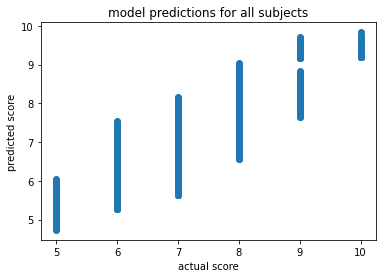

In [39]:
plt.scatter(y, yhat)
plt.xlabel('actual score')
plt.ylabel('predicted score')
plt.title('model predictions for all subjects')
plt.show()

In [41]:
def plot_subj(sub):

    yhat = pipe.predict(X[subj == sub], group = subj[subj == sub])
    ysub = y[subj == sub]

    plt.scatter(ysub, yhat)
    plt.xlabel('actual score')
    plt.ylabel('predicted score')
    plt.title('model predictions for subject %d'%sub)
    plt.show()

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


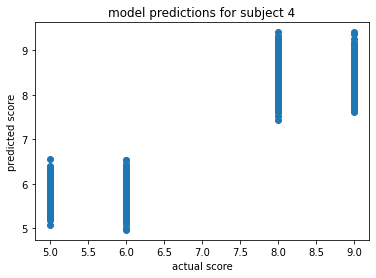

In [43]:
plot_subj(4) # a subject with great differentiation

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


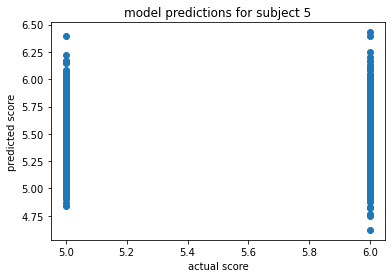

In [44]:
plot_subj(5) # a subject with less good differentiation

Of course all these predictions are off of single samples of EDA/HR, and you'll want to consider multiple samples at once. I'm guessing performance will improve when aggregating across time. Just maintain a rolling average of the model predictions.

You can also use the model to predict the probability that the score falls with an interval, rather than just a point prediction. This is useful if you're trying to predict whether a subject is going to fall below a certain performance threshold. For some obscure `sklearn` reasons, the syntax for making this prediction is slightly more complicated:

In [45]:
proba = pipe[-1].predict_proba(pipe[0].transform(X), group = subj, high = 5, low = 0)

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


When you train a model, it's always a good idea to look at the fitted parameters, so their posterior distributions are plotted below. 

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


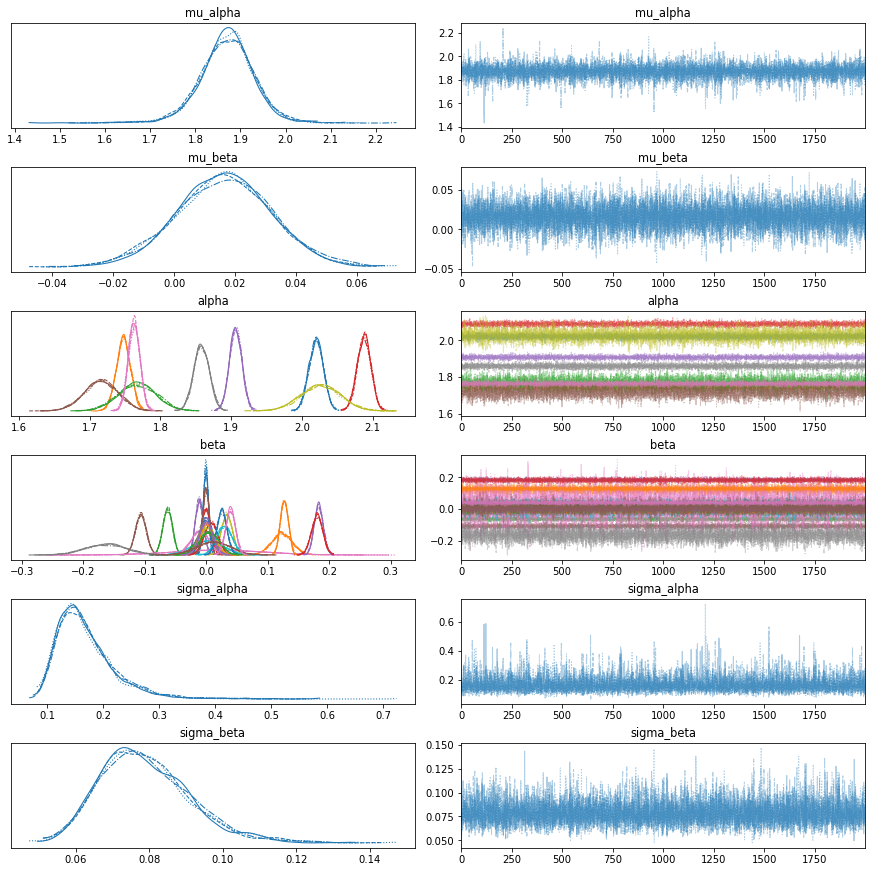

In [46]:
ax = pipe[-1].plot_posterior()

One last thing to note is that the model predictions depend on the value of `offload` (or in the original dataset termonology, the `help` indicator), which is obviously confounded with the subjects' level of cognitive effort. Since you're going to have robots offer help when the subject's performance is predicted to be low (relative to their own performance), predictions may not be reliable immediately after help is initiated. Thus, you should allow an appropriate adjustment period after help begins. (I don't know what an "appropriate" adjustment period is, I assume just until the EDA has had time to level off. You'll have to use your judgement.)

## Saving and Loading

A trained model can be saved just like an `sklearn` model using `joblib`:

In [47]:
from joblib import dump
dump(pipe, 'trained_model.joblib') # stores model
dump(le, 'label_encoder.joblib') # stores subject ID to int code crosswalk

['label_encoder.joblib']

And reloaded later:

In [48]:
# you'll need to remind Python of the class definitions if in a new process
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from util.model import HierarchicalPoissonRegression 

# after that, just
from joblib import load
reloaded_pipe = load('trained_model.joblib')
reloaded_le = load('label_encoder.joblib')

Then you can start making predictions again:

In [49]:
subj = reloaded_le.transform(data.subject.to_numpy())
yhat = reloaded_pipe.predict(X, group = subj)

/home/synsi/anaconda3/envs/eda/lib/python3.9/site-packages/pymc3/distributions/posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


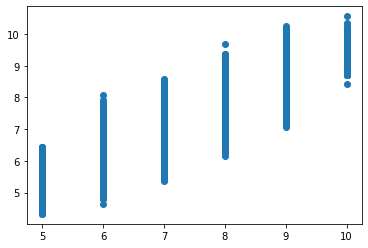

In [50]:
plt.scatter(y, yhat)